In [15]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import glob
import zipfile
import tqdm
import xarray as xr
import os
import pyart
from cartopy import geodesic
import shapely

def reconstruct_grid(f, group_id):
        
        #From h5 grid objects (f), reconstruct the radar grid
        
        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]
        
        return recon, x, y

def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0, second=0)) & (file_dates <= times[1].replace(hour=0, minute=0,second=0))]
        extract_to = "/scratch/w40/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60), time+dt.timedelta(seconds=60)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
        
    #radar_file = pyart.io.read_grid(target_files[0])
    radar_file = xr.open_dataset(target_files[0])
    
    _ = [os.remove(f) for f in grid_files]
    
    return radar_file   

def plot_stns(state, ax, stns=False):
    
    names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                    "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
    stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
            names=names, header=0)    
    if stns:
        stn_df = stn_df[np.in1d(stn_df.stn_no, stns)]
        ax.plot(stn_df.lon, stn_df.lat, marker="^", color="tab:blue", linestyle="none", ms=12, mec="k", mew=1)
    else:    
        ax.plot(stn_df.lon, stn_df.lat, marker="^", color="tab:blue", linestyle="none", ms=12, mec="k", mew=1)   
        
def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle=":")    
    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

In [16]:
print("Strongest SCW...\n")
pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/2_scw_envs_df.csv").sort_values("gust",ascending=False).iloc[0][["dt_utc","gust","stn_id","wgr_4","cluster","group_id"]]

Strongest SCW...



dt_utc      2009-04-14 19:15:00
gust                       38.6
stn_id                    90035
wgr_4                  2.095794
cluster                       0
group_id     20090414191229/250
Name: 8, dtype: object

In [17]:
df = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/2_20090401_20090430_aws.csv")

print(df.query("in10km==0").sort_values("gust",ascending=False).iloc[0:5],"\n\n")


                      dt_utc            group_id    scan   uid0  uid10  uid20  \
1115938  2009-04-26 01:04:00   20090426010029/-1  5791.0   -1.0   -1.0   -1.0   
1115941  2009-04-26 01:07:00   20090426010630/-1  5792.0   -1.0   -1.0   -1.0   
451898   2009-04-14 20:29:00  20090414202429/277  3201.0  277.0  277.0  277.0   
1115903  2009-04-26 00:29:00   20090426002429/-1  5785.0   -1.0   -1.0   -1.0   
1115829  2009-04-25 23:15:00   20090425231229/-1  5773.0   -1.0   -1.0   -1.0   

         dist0km  dist10km  dist20km  in0km  in10km  in20km  stn_id  gust  q  
1115938    0.000     0.000     0.000    0.0     0.0     0.0   90035  29.3  Y  
1115941    0.000     0.000     0.000    0.0     0.0     0.0   90035  28.8  Y  
451898    68.283    68.283    68.283    0.0     0.0     0.0   86372  28.8  Y  
1115903    0.000     0.000     0.000    0.0     0.0     0.0   90035  28.3  Y  
1115829    0.000     0.000     0.000    0.0     0.0     0.0   90035  28.3  Y   




In [18]:
df = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/era5_aws_tint_2_20090401_20090430_max.pkl")
df=df.set_index(pd.DatetimeIndex(df.dt_utc))
df.query("(stn_id==90035)").loc[slice("2009-04-25 05:50","2009-04-25 06:40")][["dt_utc","in10km","uid10","stn_id","field_max","gust","group_id","area_km"]]

,dt_utc,in10km,uid10,stn_id,field_max,gust,group_id,area_km
dt_utc,,,,,,,,
2009-04-25 05:50:00,2009-04-25 05:50:00,0.0,402.0,90035,46.000,20.6,20090425054832/402,2250.0
2009-04-25 05:51:00,2009-04-25 05:51:00,0.0,402.0,90035,46.000,23.1,20090425054832/402,2250.0
2009-04-25 05:52:00,2009-04-25 05:52:00,0.0,402.0,90035,46.000,23.1,20090425054832/402,2250.0
2009-04-25 05:53:00,2009-04-25 05:53:00,0.0,402.0,90035,46.000,24.7,20090425054832/402,2250.0
2009-04-25 05:54:00,2009-04-25 05:54:00,0.0,403.0,90035,47.688,21.1,20090425055426/403,579.0
2009-04-25 05:55:00,2009-04-25 05:55:00,0.0,403.0,90035,47.688,20.1,20090425055426/403,579.0
2009-04-25 05:56:00,2009-04-25 05:56:00,0.0,403.0,90035,47.688,23.7,20090425055426/403,579.0
2009-04-25 05:57:00,2009-04-25 05:57:00,0.0,403.0,90035,47.688,22.1,20090425055426/403,579.0
2009-04-25 05:58:00,2009-04-25 05:58:00,0.0,403.0,90035,47.688,24.7,20090425055426/403,579.0


In [94]:
def plot_driver(file_id,group_id,uid10,ax,ax_aws,ax_era5,gust_dt,lat,lon,stns,state="vic"):

    time_dt = dt.datetime.strptime(group_id[0:14], "%Y%m%d%H%M%S")
    time=group_id[0:14]
    
    #if int(group_id.split("/")[1]) >= 0:
        #rid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")    
        #r, x, y = reconstruct_grid(rid,group_id)
        # out = np.zeros(rid["lat/lat"][:].shape)    
        # out = np.where(r==1, 1, out)
        # c=ax.contour(x,y,out,levels=[0.5],colors=["k"],linewidths=3)
        
    cnt=1
    rid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    if time in list(rid.keys()):
        for uid in list(rid[time].keys()):
            out = np.zeros(rid["lat/lat"][:].shape)
            r, x, y = reconstruct_grid(rid,time+"/"+uid)
            out = np.where(r==1, cnt, out)        
            cnt=cnt+1        
            if uid == uid10:
                c=ax.contour(x,y,out,colors=["k"],linewidths=3)        
            else:
                c=ax.contour(x,y,out,colors=["k"],linewidths=1)                        
        
    radar = load_radar(file_id.split("_")[0], time_dt).isel({"time":0,"nradar":0}).max("z")
    x=radar.longitude.values
    y=radar.latitude
    c=ax.contourf(x,y,radar.corrected_reflectivity,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(-20,70,5),extend="both")
    plt.colorbar(c,ax=ax)
    plot_range_rings(radar.origin_longitude.values,radar.origin_latitude.values,150,ax)
    ax.plot(radar.origin_longitude.values,radar.origin_latitude.values,marker="+",mew=2,color="k",ms=12)
    ax.set_title(time_dt.strftime("%Y-%m-%d %H:%M") + " UTC")
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])            
    ax.coastlines()
    g1=ax.gridlines(draw_labels=True, linestyle=":"); g1.right_labels=False; g1.top_labels=False    
    g1.xlabel_style = {'fontsize': 12, 'color': 'k', 'rotation':0}
    g1.ylabel_style = {'size': 12, 'color': 'k'}
    
    aws = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+file_id+"_aws.csv")
    aws = aws.set_index(pd.DatetimeIndex(aws["dt_utc"])).sort_index()
    df = aws.query("stn_id=="+str(stns[0])).loc[slice(time_dt+dt.timedelta(hours=-2), time_dt+dt.timedelta(hours=+2))]
    df.gust.plot(ax=ax_aws)
    ax_aws.grid(axis="y")
    ax_aws.set_ylim([0,40])
    ax_aws.axhline(df.gust.mean(),ls="--",color="k")
    ax_aws.axhline(df.gust.mean()*1.5,ls="--",color="tab:orange")
    ax_aws.axhline(df.gust.max(),ls="--",color="tab:blue")    
    ax_aws.set_xlabel("UTC")
    ax_aws.axvline(gust_dt,ls=":",color="k")
    ax_aws.set_ylabel("Wind gust (m/s)")
    
    for i in np.arange(df.shape[0]-1):
        if df.iloc[i].in10km==1:
            ax_aws.axvspan(df.iloc[i].dt_utc,df.iloc[i+1].dt_utc,color="k",alpha=0.05)
    
    ds = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"+file_id.split("_")[1]+"_"+file_id.split("_")[2]+".nc")
    era5_mask = (xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc").\
                    isel({"time":0}).sel({"longitude":ds.lon, "latitude":ds.lat}).lsm >= 0.5).values
    ds = xr.where(era5_mask>=0.5, ds.sel({"time":gust_dt.replace(minute=0,second=0)}).mu_cape, np.nan)

    ds.plot(ax=ax_era5,vmin=0,levels=[0,25,50,100,250,500,1000],cmap=plt.get_cmap("YlGnBu"))
    ax_era5.set_xlim([143,146])
    ax_era5.set_ylim([-39.5,-36.5])
    ax_era5.coastlines()
    plot_range_rings(lon,lat,50,ax_era5)
    plot_stns(state, ax_era5, stns)

    x,y=np.meshgrid(ds.lon.values, ds.lat.values)
    
    dist=latlon_dist(lat, lon, y, x)
    dist[ds.isnull()] = np.nan
    p=np.argwhere((dist<50))
    ax_era5.plot(ds.lon[p[:,1]].values,ds.lat[p[:,0]].values,ls="none",marker="x",ms=8,color="k")
    g1=ax_era5.gridlines(draw_labels=True, linestyle=":"); g1.right_labels=False; g1.top_labels=False    
    g1.xlabel_style = {'fontsize': 12, 'color': 'k', 'rotation':0}
    g1.ylabel_style = {'size': 12, 'color': 'k'}
    
    plot_stns(state, ax, stns)
    
    if state=="vic":
        ax_era5.set_xlim([143,146])
        ax_era5.set_ylim([-39.5,-36.5])
    elif state=="qld":
        ax_era5.set_xlim([151.5,154.5])
        ax_era5.set_ylim([-28.5,-25.5])
        
    return df

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword

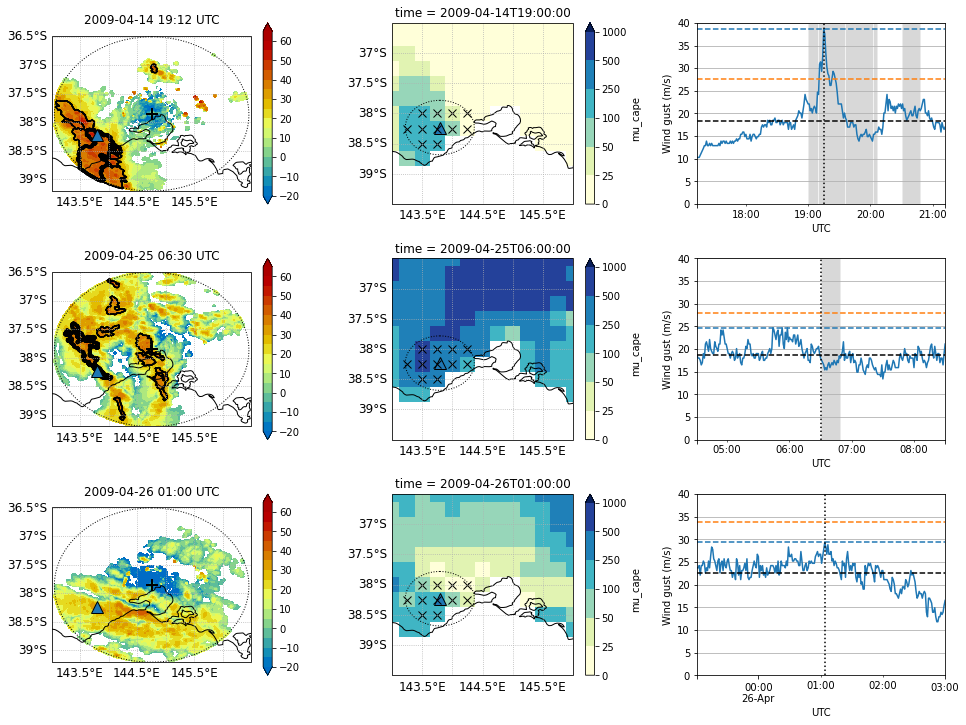

In [11]:
plt.figure(figsize=[16,12])
ax1=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
ax2=plt.subplot(3,3,3)
ax3=plt.subplot(3,3,2,projection=ccrs.PlateCarree())

ax4=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
ax5=plt.subplot(3,3,6)
ax6=plt.subplot(3,3,5,projection=ccrs.PlateCarree())

ax7=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
ax8=plt.subplot(3,3,9)
ax9=plt.subplot(3,3,8,projection=ccrs.PlateCarree())


plt.subplots_adjust(hspace=0.3, wspace=0.3)

_=plot_driver("2_20090401_20090430","20090414191229/250",ax1,ax2,ax3,dt.datetime(2009,4,14,19,15,0),-38.2332,143.7924,[90035])
_=plot_driver("2_20090401_20090430","20090425063027/410",ax4,ax5,ax6,dt.datetime(2009,4,25,6,30,27),-38.2332,143.7924,[90035])
_=plot_driver("2_20090401_20090430","20090426010029/-1",ax7,ax8,ax9,dt.datetime(2009,4,26,1,4,0),-38.2332,143.7924,[90035])

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/method_example.jpeg",dpi=1000,bbox_inches="tight")

In [12]:
temp=pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/2_scw_envs_df.csv")
temp=temp.set_index(pd.DatetimeIndex(temp["dt_utc"]))
print(temp.loc["2020-08-27"][["wgr_4","Lightning_observed","gust","in10km","field_max","group_id","stn_id"]])
print(temp.loc["2020-01-31"][["wgr_4","Lightning_observed","gust","in10km","field_max","group_id"]])

                       wgr_4  Lightning_observed  gust  in10km  field_max  \
dt_utc                                                                      
2020-08-27 07:49:00  1.79189                 0.0  29.3     1.0     47.875   

                               group_id  stn_id  
dt_utc                                           
2020-08-27 07:49:00  20200827074831/508   86220  
                        wgr_4  Lightning_observed  gust  in10km  field_max  \
dt_utc                                                                       
2020-01-31 03:47:00  3.134420                 1.0  33.1     1.0     54.188   
2020-01-31 05:04:00  3.288642                 1.0  26.9     1.0     47.375   
2020-01-31 07:22:00  4.053056                 1.0  33.6     1.0     50.062   

                                group_id  
dt_utc                                    
2020-01-31 03:47:00  20200131034228/1904  
2020-01-31 05:04:00  20200131050031/1942  
2020-01-31 07:22:00  20200131071828/1954  


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(


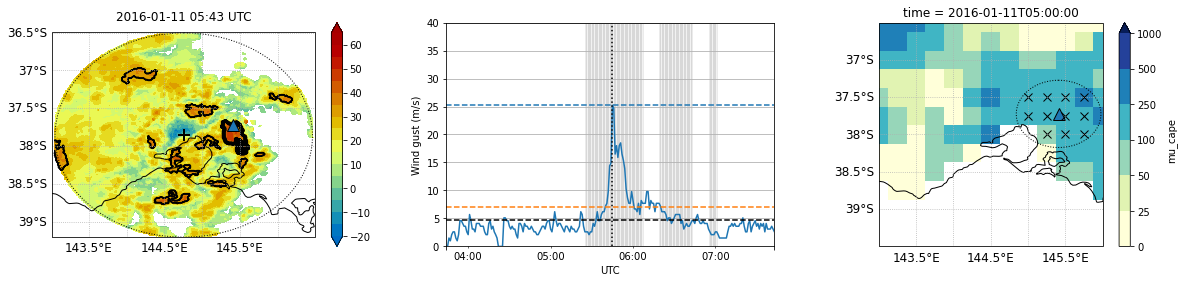

In [124]:
plt.figure(figsize=[20,14])
# ax1=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
# ax2=plt.subplot(3,3,2)
# ax3=plt.subplot(3,3,3,projection=ccrs.PlateCarree())

# time = dt.datetime(2020,8,27,7,49,0)
# lat=-37.8640
# lon=144.9639
# stns=[temp.loc[time].stn_id]
# _=plot_driver("2_20200801_20200831","20200827074831/508",508,ax1,ax2,ax3,time,lat,lon,stns)

# ax1=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
# ax2=plt.subplot(3,3,5)
# ax3=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
# lat=-38.2332
# lon=143.7924
# _=plot_driver("2_20200101_20200131","20200131034228/1904",1904,ax1,ax2,ax3,dt.datetime(2020,1,31,3,47,0),lat,lon,[90035])

# ax1=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
# ax2=plt.subplot(3,3,8)
# ax3=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
# lat=-37.6624
# lon=144.8193
# _=plot_driver("2_20201201_20201231","20201227065521/1133","1142",ax1,ax2,ax3,dt.datetime(2020,12,27,6,55,0),lat,lon,[86398],state="vic")

ax1=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
ax2=plt.subplot(3,3,8)
ax3=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
lat=-37.7239
lon=145.4092
_=plot_driver("2_20160101_20160131","20160111054319/273","273",ax1,ax2,ax3,dt.datetime(2016,1,11,5,45,0),lat,lon,[86383],state="vic")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1711: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(


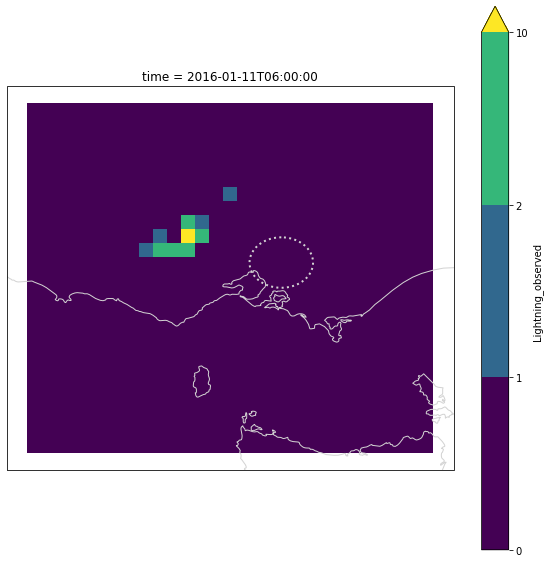

In [128]:
def load_lightning(fid):
        yyyymmdd1 = fid.split("_")[1]
        yyyymmdd2 = fid.split("_")[2]
        start_t = dt.datetime(int(yyyymmdd1[0:4]), int(yyyymmdd1[4:6]), int(yyyymmdd1[6:8]))
        end_t = dt.datetime(int(yyyymmdd2[0:4]), int(yyyymmdd2[4:6]), int(yyyymmdd2[6:8])) + dt.timedelta(days=1)

        f = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning/lightning_Australasia0.250000degree_6.00000hr_"+yyyymmdd1[0:4]+".nc",\
            decode_times=False)
        f = f.assign_coords(time=[dt.datetime(int(yyyymmdd1[0:4]),1,1,0) + dt.timedelta(hours=int(i*6)) for i in np.arange(len(f.time.values))]).\
                sel({"time":slice(start_t,end_t)})
        f = f.assign_coords(lat=np.arange(f.lat.min(), f.lat.max() + 0.25, 0.25))
        f = f.assign_coords(lon=np.arange(f.lon.min(), f.lon.max() + 0.25, 0.25))
        f = f.resample({"time":"1H"}).nearest()
        return f

# l = load_lightning("2_20200801_20200831").sel({"lat":slice(-41,-35),"lon":slice(141,148)})
# plt.figure(figsize=[10,10])
# ax=plt.axes(projection=ccrs.PlateCarree())
# l.sel({"time":"2020-08-27 06:00"})["Lightning_observed"].plot(levels=[0,1,2,10])
# ax.coastlines(color="lightgray")
# lat=-37.8640
# lon=144.9639
# ax=plot_range_rings(lon,lat,50,ax,color="lightgray",lw=2)


# l = load_lightning("2_20200101_20200131").sel({"lat":slice(-41,-35),"lon":slice(141,148)})
# plt.figure(figsize=[10,10])
# ax=plt.axes(projection=ccrs.PlateCarree())
# l.sel({"time":"2020-01-31 06:00"})["Lightning_observed"].plot(levels=[0,1,2,10])
# ax.coastlines(color="lightgray")
# lat=-38.2332
# lon=143.7924
# ax=plot_range_rings(lon,lat,50,ax,color="lightgray",lw=2)

# l = load_lightning("2_20201201_20201231").sel({"lat":slice(-41,-35),"lon":slice(141,148)})
# plt.figure(figsize=[10,10])
# ax=plt.axes(projection=ccrs.PlateCarree())
# l.sel({"time":"2020-12-27 06:00"})["Lightning_observed"].plot(levels=[0,1,2,10])
# ax.coastlines(color="lightgray")
# lat=-37.6624
# lon=144.8193
# ax=plot_range_rings(lon,lat,50,ax,color="lightgray",lw=2)

l = load_lightning("2_20160101_20160131").sel({"lat":slice(-41,-35),"lon":slice(141,148)})
plt.figure(figsize=[10,10])
ax=plt.axes(projection=ccrs.PlateCarree())
l.sel({"time":"2016-01-11 06:00"})["Lightning_observed"].plot(levels=[0,1,2,10])
ax.coastlines(color="lightgray")
lat=-37.7239
lon=145.4092
ax=plot_range_rings(lon,lat,50,ax,color="lightgray",lw=2)

In [130]:
f = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning/lightning_Australasia0.250000degree_6.00000hr_"+"2016"+".nc",\
    decode_times=False)
f.time
# f = f.assign_coords(time=[dt.datetime(2020,1,1,0) + dt.timedelta(hours=int(i*6)) for i in np.arange(len(f.time.values))]).\
#         sel({"time":"2020-12-27 06:00"})
# plt.figure(figsize=[10,8])
# ax=plt.axes(projection=ccrs.PlateCarree())

# f.Lightning_observed.plot(levels=[0,1,2,5,10,100,1000],ax=ax)

# ax.coastlines(color="lightgray")

<xarray.DataArray 'time' (time: 1464)>
array([   0,    1,    2, ..., 1461, 1462, 1463], dtype=int32)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 ... 1457 1458 1459 1460 1461 1462 1463
Attributes:
    units:    Hours since 00 UT January 1

In [129]:
l.time

<xarray.DataArray 'time' (time: 745)>
array(['2016-01-01T00:00:00.000000000', '2016-01-01T01:00:00.000000000',
       '2016-01-01T02:00:00.000000000', ..., '2016-01-31T22:00:00.000000000',
       '2016-01-31T23:00:00.000000000', '2016-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-01T01:00:00 ... 2016-02-01